In [1]:
import numpy as np
from nn import nn # Import your NeuralNetwork class
from nn import preprocess
from nn import io
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


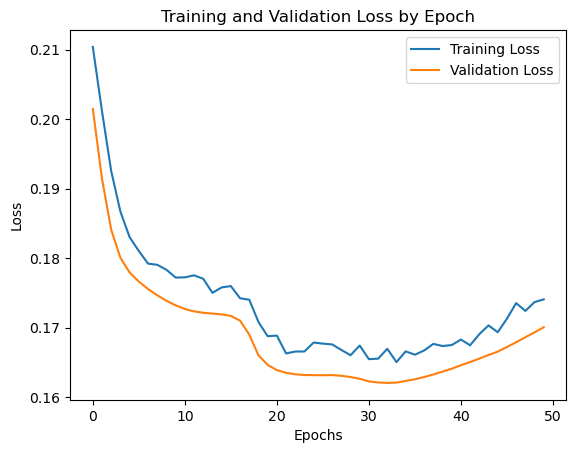

Average Reconstruction Error: 0.170066

- Learning Rate (0.01): Chosen for moderate training speed without overshooting.
- Batch Size (32): A small batch size ensures smoother updates to weights.
- Epochs (50): Provides enough training for convergence.
- Loss Function (MSE): Used for autoencoder reconstruction error.



In [2]:
# Load the digits dataset
digits = load_digits()
X = digits.data  # Shape (1797, 64)

# Normalize pixel values to [0,1] range
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into training and validation sets
X_train, X_val = train_test_split(X, test_size=0.8, random_state=42)


# Define the autoencoder architecture
autoencoder_arch = [
    {"input_dim": 64, "output_dim": 16, "activation": "relu"},
    {"input_dim": 16, "output_dim": 64, "activation": "relu"}
]

# Initialize the neural network model
autoencoder = nn.NeuralNetwork(
    nn_arch=autoencoder_arch,
    lr=0.01,
    seed=42,
    batch_size=32,
    epochs=50,
    loss_function="mean_squared_error"
)

# Train the autoencoder
train_loss, val_loss = autoencoder.fit(X_train, X_train, X_val, X_val)

# Plot training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss by Epoch')
plt.show()

# Compute average reconstruction error on validation set
X_val_reconstructed = autoencoder.predict(X_val)
reconstruction_error = np.mean(np.power(X_val - X_val_reconstructed, 2))
print(f'Average Reconstruction Error: {reconstruction_error:.6f}')

# Explanation of hyperparameters
hyperparam_explanation = '''
- Learning Rate (0.01): Chosen for moderate training speed without overshooting.
- Batch Size (32): A small batch size ensures smoother updates to weights.
- Epochs (50): Provides enough training for convergence.
- Loss Function (MSE): Used for autoencoder reconstruction error.
'''
print(hyperparam_explanation)


In [3]:
pos_seqs = io.read_text_file("data/rap1-lieb-positives.txt")
neg_seqs = io.read_fasta_file("data/yeast-upstream-1k-negative.fa")

labels = ([True] * len(pos_seqs)) + [False] * (len(neg_seqs))

all_seqs = pos_seqs + neg_seqs
sampled_seqs, sampled_labels = preprocess.sample_seqs(all_seqs, labels)

sampled_one_hot_seqs = (preprocess.one_hot_encode_seqs(sampled_seqs))

max_len = 0
for row in sampled_one_hot_seqs:
    seq_len = len(row)
    if seq_len > max_len:
        max_len = seq_len

padded_one_hot_seqs = []

for row in sampled_one_hot_seqs:
    seq_len = len(row)
    pad_length = max_len - seq_len
    pad = [2] * pad_length
    row = row + pad
    padded_one_hot_seqs.append(row)


converted_labels = np.array(sampled_labels, dtype=int)
X = np.asarray(padded_one_hot_seqs)
y = converted_labels


In [4]:
len(converted_labels)

6326

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Add these print statements before calling fit()
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

# Ensure y is a column vector
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
# Define the neural network architecture
nn_architecture = [
    {'input_dim': 4000, 'output_dim': 512, 'activation': 'relu'},
    {'input_dim': 512, 'output_dim': 128, 'activation': 'relu'},
    {'input_dim': 128, 'output_dim': 32, 'activation': 'relu'},
    {'input_dim': 32, 'output_dim': 1, 'activation': 'sigmoid'}
]

# Set hyperparameters
learning_rate = 0.001
random_seed = 42
batch_size = 32
max_epochs = 50
loss_function = 'binary_cross_entropy'  # Appropriate for binary classification

# Initialize the model
classifier = nn.NeuralNetwork(
    nn_arch=nn_architecture,
    lr=learning_rate,
    seed=random_seed,
    batch_size=batch_size,
    epochs=max_epochs,
    loss_function=loss_function
)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Train the model
train_loss, val_loss = classifier.fit(X_train, y_train, X_val, y_val)

# Make predictions
y_pred = classifier.predict(X_val)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

X_train shape: (5060, 4000)
y_train shape: (5060,)
X_val shape: (1266, 4000)
y_val shape: (1266,)
Layer 1: {'input_dim': 4000, 'output_dim': 512, 'activation': 'relu'}
W1 shape: (512, 4000)
b1 shape: (512, 1)
----
Layer 2: {'input_dim': 512, 'output_dim': 128, 'activation': 'relu'}
W2 shape: (128, 512)
b2 shape: (128, 1)
----
Layer 3: {'input_dim': 128, 'output_dim': 32, 'activation': 'relu'}
W3 shape: (32, 128)
b3 shape: (32, 1)
----
Layer 4: {'input_dim': 32, 'output_dim': 1, 'activation': 'sigmoid'}
W4 shape: (1, 32)
b4 shape: (1, 1)
----


ValueError: operands could not be broadcast together with shapes (128,512) (32,32) (128,512) 